# Объединённая метрика на базе синтетических данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json, glob

def tprfpr(A, B):
    dt = np.array([[v, 1] for v in A] + [[v, 0] for v in B])
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    return (tpr, fpr, dt)

def accuracy(A, B):
    tpr, fpr, dt = tprfpr(A, B)
    dst = [(x**2 + (1-y)**2) for x,y in np.transpose([fpr, tpr])]
    t_ = dt[np.argmin(dst)][0]
    acc = 0.5 * (len(A[A < t_])/len(A) + len(B[B >= t_])/len(B))
    return (acc, t_)

def params(s, index):
    return (np.mean([v[index] for v in s]), np.std([v[index] for v in s]))

In [2]:
synt = {}
for cov in ['15', '30', '75', '300']:
    synt[cov] = {'good': [], 'bad': []}
    for aber in ['DEL_1.0', 'DUP_2.0']:
        with open(f'../../data/generated_m/brownian_{cov}_{aber}.json', 'r') as f:
            tmp = json.load(f)
            [synt[cov]['good'].append([a[1], a[3]]) for a in tmp if a[0] == 0]
            [synt[cov]['bad'].append([a[1], a[3]]) for a in tmp if a[0] == 256]
    synt[cov]['good'] = np.array(synt[cov]['good'])
    synt[cov]['bad'] = np.array(synt[cov]['bad'])

# Normalise (mean + std)
fft_n, fft_s = params(synt['300']['good'], 0)
dtt_n, dtt_s = params(synt['300']['good'], 1)

In [3]:
def transform(obj, dx, dy):
    nrm = (obj - [fft_n, dtt_n])/[fft_s, -dtt_s] + [5, 5]
    return np.array([((x * dx) + (y * dy)) for x, y in nrm])

def target(dx, dy):
    acc = 0
    for cov in ['15', '30', '75', '300']:
        acc_, t_ = accuracy(transform(synt[cov]['good'], dx, dy), transform(synt[cov]['bad'], dx, dy))
        acc += acc_
    return acc

In [11]:
def search(x_, y_):
    delta, speed, steps = (0.05, 50, 29)
    values = []
    for step in range(steps):
        xl, xr = (target(x_ + delta, y_), target(x_ - delta, y_))
        yl, yr = (target(x_, y_ + delta), target(x_, y_ - delta))
        dx, dy = (xl - xr, yl - yr)
        x_, y_ = (x_ + speed * dx, y_ + speed * dy)
        vv = np.mean([xl, xr, yl, yr])
        # print(f"Step: {step}, dx:{dx:.5f}, dy:{dy:.5f}")
        # print(f"NEW: [{x_:.3f}, {y_:.3f}]; V = {vv:.3f}")
        values.append([x_, y_, vv])
    return values

In [20]:
lists = []
for i in range(20):
    xx, yy = np.random.sample(2) * 10
    lists.append(search(xx, yy))

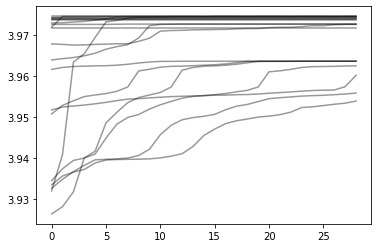

In [37]:
for L in lists:
    plt.plot([e[2] for e in L], alpha=0.4, color='#000')

In [31]:
SL = sorted([[L[-1][2], L[-1][0], L[-1][1]] for L in lists])
v, xx, yy = SL[-1]
SL

[[3.9538671875, 2.727323163428811, 9.341178350781785],
 [3.9558203125, 2.554863804349099, 7.760783054989938],
 [3.9601562500000003, 3.5355365208804193, 9.711402899963755],
 [3.9624609375000004, 2.4913335030040304, 6.0382038936695706],
 [3.9635937500000002, 2.02443587993663, 4.46781658899397],
 [3.9635937500000002, 2.220149702897726, 4.921188250611343],
 [3.9635937500000002, 2.2854213310487292, 5.058320872548691],
 [3.97171875, 6.881759392629453, 9.310015073229666],
 [3.972578125, 4.167905288548063, 5.316681907180372],
 [3.97265625, 1.7624149575098191, 2.1785706948533545],
 [3.97265625, 4.838573391646412, 6.097425195147773],
 [3.97359375, 5.99650816942561, 5.467578516427394],
 [3.97390625, 7.2554403681593875, 6.1088901818575],
 [3.97390625, 8.04163403110248, 4.69676053279533],
 [3.9740625, 9.753667567244898, 6.435460561076541],
 [3.974375, 7.63998911325175, 1.809490705812199],
 [3.974375, 8.431900002665792, 1.9903177236926883],
 [3.97453125, 3.7650000310870766, 1.1030704463920715],
 [3.

In [38]:
xx, yy

(3.473061644814993, 0.9505966676489108)

In [40]:
real = {'good': [], 'bad': []}
for aber in ['DEL_1.0', 'DUP_2.0']:
    with open(f'../../data/generated_m/real_good_{aber}.json', 'r') as f:
        tmp = json.load(f)
        [real['good'].append([a[1], a[3]]) for a in tmp if a[0] == 0]
        [real['bad'].append([a[1], a[3]]) for a in tmp if a[0] == 512]
real['good'] = np.array(real['good'])
real['bad'] = np.array(real['bad'])

In [50]:
# DTCWT
A, B = (np.array([v[1] for v in real['good']]), np.array([v[1] for v in real['bad']]))
accuracy(A, B)

(0.4935064935064935, 9.274924309767579)

In [51]:
# FFT
A, B = (np.array([v[0] for v in real['good']]), np.array([v[0] for v in real['bad']]))
accuracy(A, B)

(0.9935064935064934, 1338.7535860818712)

In [53]:
# Combined
A, B = (transform(real['good'], xx, yy), transform(real['bad'], xx, yy))
accuracy(A, B)

(0.9935064935064934, 33.43645918019578)

## К

In [ ]:
with open(f'../../data/generated_m/brownian_{cov}_{aber}.json', 'r') as f:
    tmp = json.load(f)